# Neural/MLForecast

This example notebook demonstrates the compatibility of HierarchicalForecast's reconciliation methods with popular machine-learning libraries, specifically [NeuralForecast](https://github.com/Nixtla/neuralforecast) and [MLForecast](https://github.com/Nixtla/mlforecast).

The notebook utilizes NBEATS and XGBRegressor models to create base forecasts for the TourismLarge Hierarchical Dataset. After that, we use HierarchicalForecast to reconcile the base predictions.

**References**<br>
- [Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting". url: https://arxiv.org/abs/1905.10437](https://arxiv.org/abs/1905.10437)<br>
- [Tianqi Chen and Carlos Guestrin. “XGBoost: A Scalable Tree Boosting System”. In: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. KDD ’16. San Francisco, California, USA: Association for Computing Machinery, 2016, pp. 785–794. isbn: 9781450342322. doi: 10.1145/2939672.2939785. url: https://doi.org/10.1145/2939672.2939785 (cit. on p. 26).](https://doi.org/10.1145/2939672.2939785)<br>


You can run these experiments using CPU or GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/MLFrameworksExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing packages

In [ ]:
%%capture
!pip install datasetsforecast hierarchicalforecast mlforecast neuralforecast 

In [ ]:
import numpy as np
import pandas as pd

from datasetsforecast.hierarchical import HierarchicalData

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import GMM

from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals
import xgboost as xgb

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.methods import BottomUp, ERM, MinTrace
from hierarchicalforecast.utils import HierarchicalPlot
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import scaled_crps

## 2. Load hierarchical dataset

This detailed Australian Tourism Dataset comes from the National Visitor Survey, managed by the Tourism Research Australia, it is composed of 555 monthly series from 1998 to 2016, it is organized geographically, and purpose of travel. The natural geographical hierarchy comprises seven states, divided further in 27 zones and 76 regions. The purpose of travel categories are holiday, visiting friends and relatives (VFR), business and other. The MinT (Wickramasuriya et al., 2019), among other hierarchical forecasting studies has used the dataset it in the past. The dataset can be accessed in the [MinT reconciliation webpage](https://robjhyndman.com/publications/mint/), although other sources are available.

| Geographical Division | Number of series per division | Number of series per purpose | Total |
|          ---          |               ---             |              ---             |  ---  |
|  Australia            |              1                |               4              |   5   |
|  States               |              7                |              28              |  35   |
|  Zones                |             27                |              108             |  135  |
|  Regions              |             76                |              304             |  380  |
|  Total                |            111                |              444             |  555  |


In [ ]:
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
S_df = S_df.reset_index(names="unique_id")

In [ ]:
Y_df.head()

,unique_id,ds,y
0,TotalAll,1998-01-01,45151.071280
1,TotalAll,1998-02-01,17294.699551
2,TotalAll,1998-03-01,20725.114184
3,TotalAll,1998-04-01,25388.612353
4,TotalAll,1998-05-01,20330.035211


Visualize the aggregation matrix.

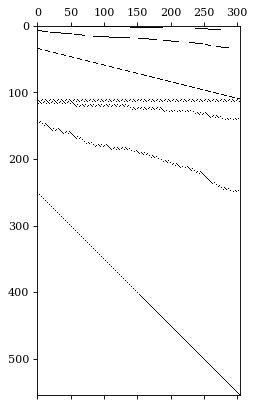

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

Split the dataframe in train/test splits.

In [ ]:
horizon = 12
Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

## 3. Fit and Predict Models

HierarchicalForecast is compatible with many different ML models. Here, we show two examples:<br>
1. NBEATS, a MLP-based deep neural architecture.<br> 
2. XGBRegressor, a tree-based architecture.<br>

In [ ]:
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in level]
quantiles = np.sort(np.concatenate(qs)[1:]/100)

#fit/predict NBEATS from NeuralForecast
nbeats = NBEATS(h=horizon,
              input_size=2*horizon,
              loss=GMM(n_components=10, quantiles=quantiles),
              scaler_type='robust',
              max_steps=2000)
nf = NeuralForecast(models=[nbeats], freq='MS')
nf.fit(df=Y_train_df)
Y_hat_nf = nf.predict().reset_index()
insample_nf = nf.predict_insample(step_size=horizon).reset_index()

#fit/predict XGBRegressor from MLForecast
mf = MLForecast(models=[xgb.XGBRegressor()], 
                freq='MS',
                lags=[1,2,12,24],
                date_features=['month'],
                )
mf.fit(Y_train_df, fitted=True, prediction_intervals=PredictionIntervals(n_windows=10, h=horizon)) 
Y_hat_mf = mf.predict(horizon, level=level)
insample_mf = mf.forecast_fitted_values()

In [ ]:
Y_hat_nf

,unique_id,ds,NBEATS,NBEATS-lo-98.0,NBEATS-lo-96.0,NBEATS-lo-94.0,NBEATS-lo-92.0,NBEATS-lo-90.0,NBEATS-lo-88.0,NBEATS-lo-86.0,...,NBEATS-hi-80.0,NBEATS-hi-82.0,NBEATS-hi-84.0,NBEATS-hi-86.0,NBEATS-hi-88.0,NBEATS-hi-90.0,NBEATS-hi-92.0,NBEATS-hi-94.0,NBEATS-hi-96.0,NBEATS-hi-98.0
0,AAAAll,2016-01-01,2843.298584,1764.249023,1806.885132,1864.019043,1906.171021,1945.994629,1965.081421,1998.606812,...,3497.682373,3520.107666,3561.643799,3600.121094,3646.954346,3703.382324,3774.084473,3813.719238,3902.713867,3991.594238
1,AAAAll,2016-02-01,1753.340698,1394.245850,1414.474976,1439.167480,1458.228394,1474.655640,1480.433472,1489.651245,...,2024.560791,2049.965576,2066.480957,2090.285156,2120.172852,2145.964844,2201.716064,2253.415039,2364.905029,2441.167480
2,AAAAll,2016-03-01,1878.675171,1446.630371,1491.637817,1513.890137,1524.787842,1532.539917,1547.460205,1559.098389,...,2172.270996,2189.489990,2216.255859,2236.661377,2286.617676,2370.431152,2411.910156,2477.557373,2579.611084,2722.415283
3,AAAAll,2016-04-01,2140.948486,1661.737793,1706.259399,1724.914551,1736.446045,1754.887695,1765.482056,1772.123901,...,2470.206543,2483.571045,2493.527588,2517.062744,2547.355713,2577.867676,2610.180908,2637.010498,2700.801758,2864.596924
4,AAAAll,2016-05-01,1834.694946,1466.314209,1485.427002,1500.715210,1518.462036,1535.386475,1543.525635,1554.429810,...,2093.700684,2120.782471,2137.882812,2154.052002,2164.069824,2189.309326,2234.271973,2311.157715,2436.267090,2659.653809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,TotalVis,2016-08-01,7362.455078,5799.121582,5960.676270,6073.553223,6230.090820,6294.191406,6365.950684,6400.492676,...,8120.279785,8144.139648,8185.699219,8212.809570,8255.871094,8291.191406,8374.907227,8435.806641,8568.060547,8770.566406
6656,TotalVis,2016-09-01,7803.098145,6455.050293,6612.847168,6690.960938,6804.897461,6848.432617,6873.607422,6904.770020,...,8562.215820,8594.000000,8642.083984,8715.201172,8795.628906,8924.573242,9053.747070,9250.514648,9410.338867,9818.623047
6657,TotalVis,2016-10-01,8478.570312,6592.350098,6818.883789,7075.323730,7223.682129,7300.230957,7336.740723,7391.779785,...,9558.611328,9586.333984,9658.816406,9761.448242,9802.087891,9870.294922,9956.144531,10070.672852,10195.408203,10342.619141
6658,TotalVis,2016-11-01,8251.816406,6471.753906,6551.861328,6621.647461,6694.992188,6740.827148,6798.824707,6825.794434,...,9519.825195,9557.507812,9624.822266,9720.269531,9811.011719,9907.259766,10132.628906,10362.583984,10896.478516,11394.652344


In [ ]:
Y_hat_mf

,unique_id,ds,XGBRegressor,XGBRegressor-lo-98,XGBRegressor-lo-96,XGBRegressor-lo-94,XGBRegressor-lo-92,XGBRegressor-lo-90,XGBRegressor-lo-88,XGBRegressor-lo-86,...,XGBRegressor-hi-80,XGBRegressor-hi-82,XGBRegressor-hi-84,XGBRegressor-hi-86,XGBRegressor-hi-88,XGBRegressor-hi-90,XGBRegressor-hi-92,XGBRegressor-hi-94,XGBRegressor-hi-96,XGBRegressor-hi-98
0,AAAAll,2016-01-01,3240.743164,2566.404620,2638.984995,2711.565370,2784.145745,2856.726120,2876.514198,2877.447884,...,3601.237386,3602.171072,3603.104758,3604.038444,3604.972130,3624.760208,3697.340583,3769.920958,3842.501333,3915.081708
1,AAAAll,2016-02-01,1583.065063,1247.414469,1248.895343,1250.376217,1251.857091,1253.337965,1263.627340,1277.062610,...,1848.761709,1862.196978,1875.632248,1889.067517,1902.502787,1912.792162,1914.273036,1915.753910,1917.234784,1918.715658
2,AAAAll,2016-03-01,2030.168213,1345.896497,1386.655046,1427.413595,1468.172144,1508.930693,1546.207337,1582.240444,...,2369.996660,2406.029767,2442.062874,2478.095981,2514.129089,2551.405733,2592.164282,2632.922831,2673.681380,2714.439928
3,AAAAll,2016-04-01,2152.282227,1767.276611,1772.956049,1778.635487,1784.314926,1789.994364,1798.503584,1808.023439,...,2467.981448,2477.501303,2487.021159,2496.541014,2506.060870,2514.570089,2520.249527,2525.928966,2531.608404,2537.287842
4,AAAAll,2016-05-01,1970.894775,1476.761973,1510.667430,1544.572887,1578.478344,1612.383801,1625.448072,1631.069062,...,2293.857519,2299.478509,2305.099499,2310.720489,2316.341479,2329.405750,2363.311207,2397.216664,2431.122121,2465.027578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,TotalVis,2016-08-01,7810.465820,6251.079674,6268.924727,6286.769780,6304.614833,6322.459886,6375.977772,6442.235956,...,8979.921135,9046.179318,9112.437501,9178.695685,9244.953868,9298.471754,9316.316807,9334.161860,9352.006913,9369.851967
6656,TotalVis,2016-09-01,6887.893555,5346.477959,5397.795065,5449.112170,5500.429275,5551.746380,5604.124112,5656.880638,...,7960.636893,8013.393419,8066.149945,8118.906472,8171.662998,8224.040729,8275.357834,8326.674940,8377.992045,8429.309150
6657,TotalVis,2016-10-01,7763.275879,6138.534738,6267.740281,6396.945824,6526.151367,6655.356910,6706.009194,6728.606744,...,8730.152366,8752.749916,8775.347465,8797.945014,8820.542563,8871.194848,9000.400391,9129.605934,9258.811477,9388.017020
6658,TotalVis,2016-11-01,7432.722168,5703.395148,5726.926242,5750.457336,5773.988430,5797.519524,5929.164698,6099.422043,...,8255.250258,8425.507603,8595.764948,8766.022293,8936.279638,9067.924811,9091.455905,9114.986999,9138.518093,9162.049187


## 4. Reconcile Predictions
With minimal parsing, we can reconcile the raw output predictions with different HierarchicalForecast reconciliation methods.

In [ ]:
reconcilers = [
    ERM(method='closed'),
    BottomUp(),
    MinTrace('mint_shrink'),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_nf = hrec.reconcile(Y_hat_df=Y_hat_nf, Y_df=insample_nf, S=S_df, tags=tags, level=level)
Y_rec_mf = hrec.reconcile(Y_hat_df=Y_hat_mf, Y_df=insample_mf, S=S_df, tags=tags, level=level)

## 5. Evaluation

To evaluate we use a scaled variation of the CRPS, as proposed by Rangapuram (2021), to measure the accuracy of predicted quantiles `y_hat` compared to the observation `y`.

$$
\mathrm{sCRPS}(\hat{F}_{\tau}, \mathbf{y}_{\tau}) = \frac{2}{N} \sum_{i}
\int^{1}_{0}
\frac{\mathrm{QL}(\hat{F}_{i,\tau}, y_{i,\tau})_{q}}{\sum_{i} | y_{i,\tau} |} dq
$$

We find that NBEATS with BottomUp reconciliation and XGB with MinTrace(mint_shrink) reconciliation result in the lowest CRPS score on the test set, thus giving us the best probabilistic forecasts.

In [ ]:
rec_model_names_nf = ['NBEATS/BottomUp', 'NBEATS/MinTrace_method-mint_shrink', 'NBEATS/ERM_method-closed_lambda_reg-0.01']
rec_model_names_mf = ['XGBRegressor/BottomUp', 'XGBRegressor/MinTrace_method-mint_shrink', 'XGBRegressor/ERM_method-closed_lambda_reg-0.01']

n_series = len(S_df)

for name in rec_model_names_nf:
    quantile_columns = [col for col in Y_rec_nf.columns if (name+'-lo') in col or (name+'-hi') in col]
    quantile_columns.remove(name+'-lo-0')
    n_quantiles = len(quantile_columns)

    y_rec  = Y_rec_nf[quantile_columns].values 
    y_test = Y_test_df['y'].values

    y_rec  = y_rec.reshape(n_series, horizon, n_quantiles)
    y_test = y_test.reshape(n_series, horizon)
    scrps  = scaled_crps(y=y_test, y_hat=y_rec, quantiles=quantiles)
    print("{:<50} {:.3f}".format(name+":", scrps))

for name in rec_model_names_mf:
    quantile_columns = [col for col in Y_rec_mf.columns if (name+'-lo') in col or (name+'-hi') in col]
    quantile_columns.remove(name+'-lo-0')
    n_quantiles = len(quantile_columns)

    y_rec  = Y_rec_mf[quantile_columns].values 
    y_test = Y_test_df['y'].values

    y_rec  = y_rec.reshape(n_series, horizon, n_quantiles)
    y_test = y_test.reshape(n_series, horizon)
    scrps  = scaled_crps(y=y_test, y_hat=y_rec, quantiles=quantiles)
    print("{:<50} {:.3f}".format(name+":", scrps))

NBEATS/BottomUp:                                   0.127
NBEATS/MinTrace_method-mint_shrink:                0.164
NBEATS/ERM_method-closed_lambda_reg-0.01:          0.192
XGBRegressor/BottomUp:                             0.134
XGBRegressor/MinTrace_method-mint_shrink:          0.130
XGBRegressor/ERM_method-closed_lambda_reg-0.01:    0.176


## 6. Visualizations

In [ ]:
plot_nf = Y_df.merge(Y_rec_nf, on=['unique_id', 'ds'], how="outer")

plot_mf = Y_df.merge(Y_rec_mf, on=['unique_id', 'ds'], how="outer")


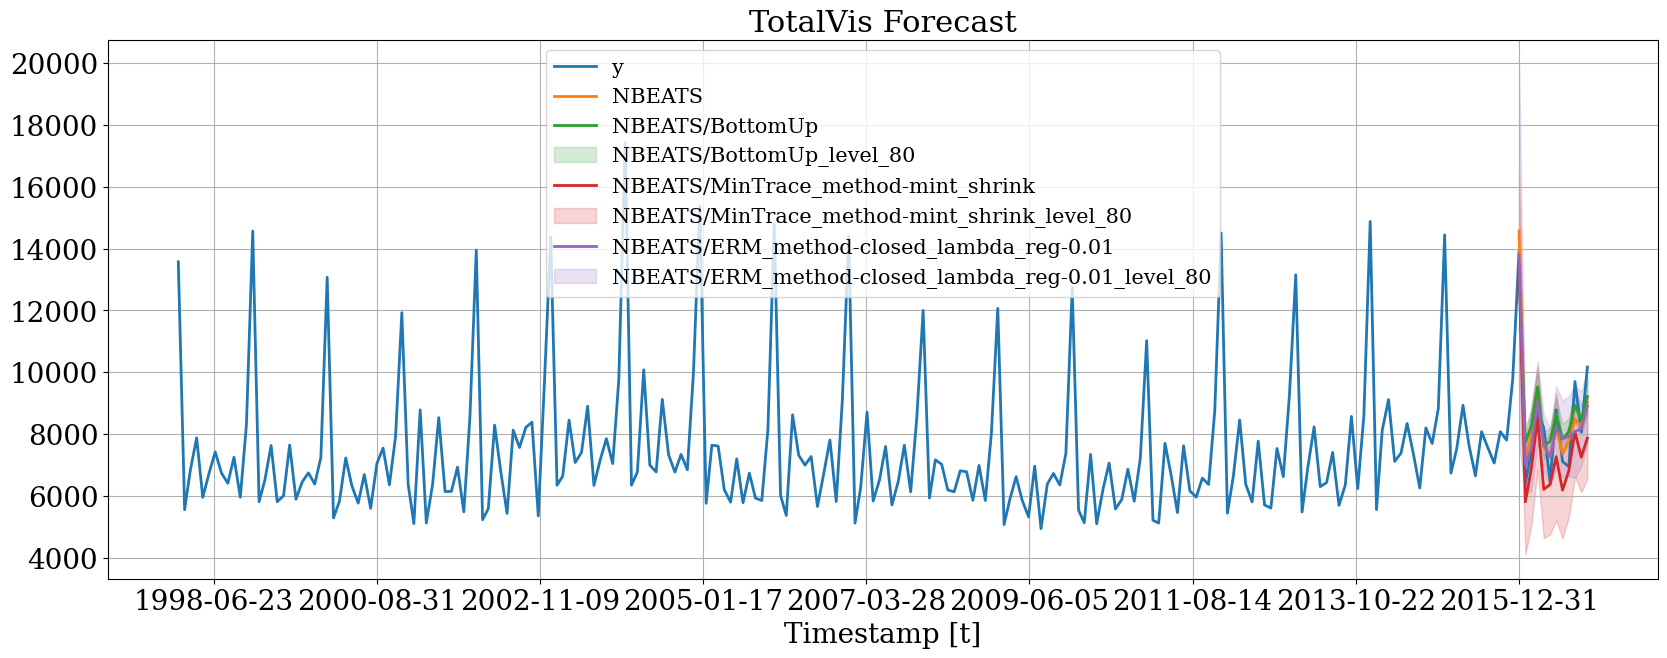

In [ ]:
hplot.plot_series(
    series='TotalVis',
    Y_df=plot_nf, 
    models=['y', 'NBEATS', 'NBEATS/BottomUp', 'NBEATS/MinTrace_method-mint_shrink', 'NBEATS/ERM_method-closed_lambda_reg-0.01'],
    level=[80]
)

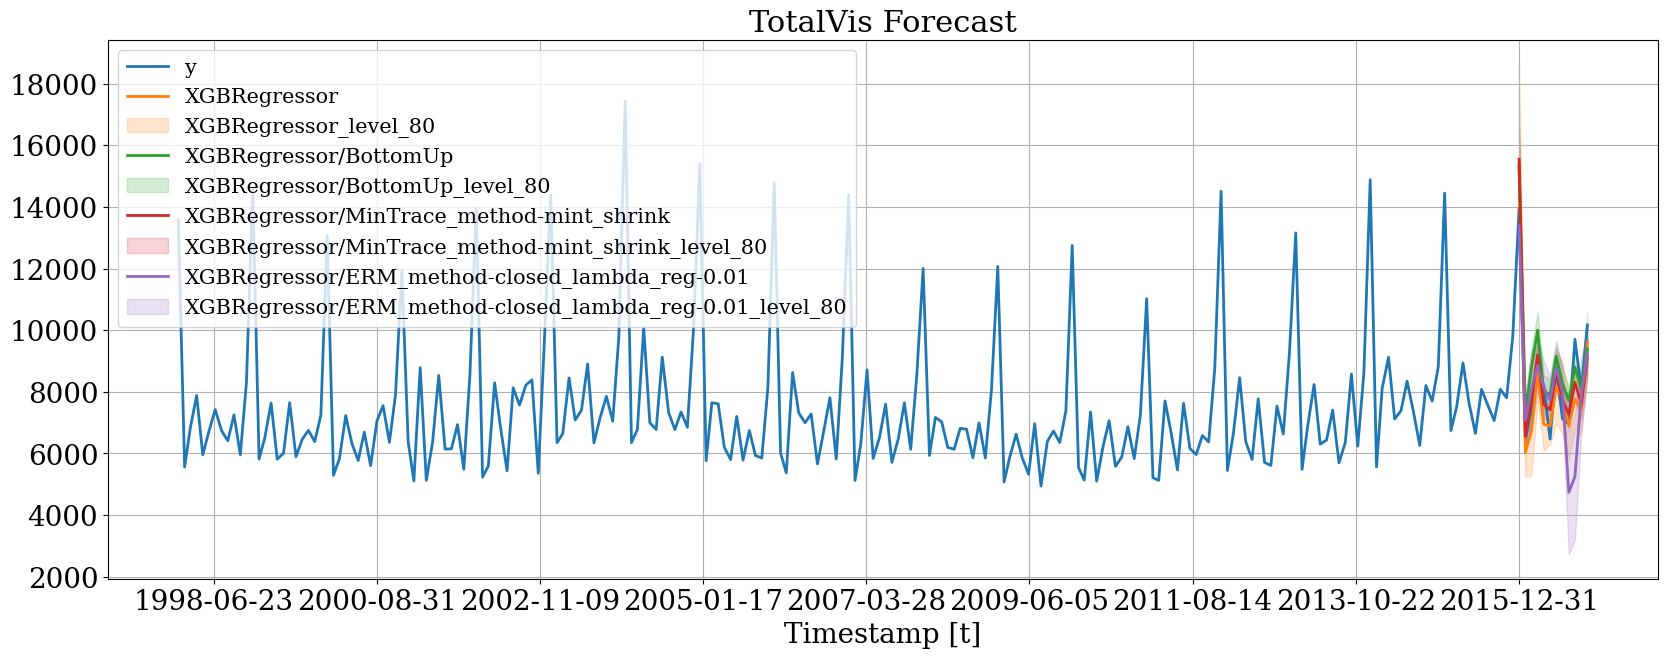

In [ ]:
hplot.plot_series(
    series='TotalVis',
    Y_df=plot_mf, 
    models=['y', 'XGBRegressor', 'XGBRegressor/BottomUp', 'XGBRegressor/MinTrace_method-mint_shrink', 'XGBRegressor/ERM_method-closed_lambda_reg-0.01'],
    level=[80]
)